In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import glob

sys.path.append('../')
from package_global_functions import *


In [30]:
path = '../frozen_positions_new'
folder = '/time_evo_indv_states_N_35_ar_20.0_ir_4.0_er_1.5_pi1_0.3_pi2_0.3_q1_7_q2_10_l_0.9'
file = 'time_evo_rea_001_config_986_indv_states.csv'
N = 35
dfq = pd.read_csv(f'{path}{folder}/{file}', names=[f's{i}' for i in range(1,N+1)], header=None)

pathmf = '../clean_version'
foldermf = '/time_evo_indv_states'
filemf = 'time_evo_rea_001_indv_states.csv'
dfmf = pd.read_csv(f'{pathmf}{foldermf}/{filemf}', names=[f's{i}' for i in range(1,N+1)], header=None)

In [ ]:
fig, ax = plt.subplots()
ax.plot(dfq.index, dfq[1])

In [ ]:
fig, ax = plt.subplots()
ax.plot(dfmf.index, dfmf[1])

In [33]:
print(len(dfq.query('s2 == 0')))
print(len(dfmf.query('s2 == 0')))

1310
209


# get the time each agent spends between 0 and 1 or bt 0 and 2

In [102]:
def get_times_spent_at_stateX(timesXin, timesYin):
    timesX, timesY = timesXin, timesYin
    # based on the assumption that timesX[0] < timesY[0]
    if timesX[0] > timesY[0]:
        timesY = timesY[timesY > timesX[0]]
    counter = 1
    times_spent_X, times_spent_Y = [], []
    for iaux,t in enumerate(timesX[1:]):
        i = iaux+1
        if t-timesX[i-1] == 1:
            counter += 1
        else:
            if len(timesY) == 0 or t < min(timesY):
                # print(i,t,timesX[i-1])
                counter += t-timesX[i-1]
            else:
                # print(i,t)
                times_spent_X.append(counter)
                counter = 1
                timesY = timesY[timesY > t]
                # print(timesY)
    # save last count:
    times_spent_X.append(counter)
    return times_spent_X



In [104]:
trialchain = [0,2,2,0,1,1,1,1,0,1,1,0,0,2,2,2,2,2,2,0,2,2,2,0,0,0,0,0,1,1,0,1,0,1,1,1,0,0,0,2,1,1,0,1]
dftrial = pd.DataFrame({'s1':trialchain})
times1 = np.array(list(dftrial.query('s1 == 1').index))
times2 = np.array(list(dftrial.query('s1 == 2').index))

times_spent_1 = get_times_spent_at_stateX(times1, times2)
print(times_spent_1)

[7, 8, 4]


In [130]:
# folders = [f'/time_evo_indv_states_N_35_ar_20.0_ir_4.0_er_1.5_pi1_0.3_pi2_0.3_q1_7_q2_10_l_{l}',
#            f'/time_evo_indv_states_N_35_ar_20.0_ir_9.0_er_1.5_pi1_0.3_pi2_0.3_q1_7_q2_10_l_{l}']

ls = [0.2, 0.9]
irs = [4.0, 9.0]

times_spent_1_var_ir_l = {}
for l in ls:
    for ir in irs:
        folder = f'/time_evo_indv_states_N_35_ar_20.0_ir_{ir}_er_1.5_pi1_0.3_pi2_0.3_q1_7_q2_10_l_{l}'
        files = glob.glob(f'{path}{folder}/*')
        times_spent_1_global = []
        for file in files:
            # print(file)
            # dfq = pd.read_csv(f'{path}{folder}/{file}', names=[f's{i}' for i in range(1,N+1)], header=None)
            dfq = pd.read_csv(f'{file}', names=[f's{i}' for i in range(1,N+1)], header=None)
            for i in range(1,N+1):
                times1 = np.array(list(dfq.query(f's{i} == 1').index))
                times2 = np.array(list(dfq.query(f's{i} == 2').index))
                if len(times1) > 0:
                    times_spent_1 = get_times_spent_at_stateX(times1, times2)
                    times_spent_1_global.extend(times_spent_1)
        times_spent_1_var_ir_l[(ir,l)] = times_spent_1_global

In [131]:
for l in ls:
    for ir in irs:
        print(f'ir = {ir}, l = {l}: {np.average(times_spent_1_var_ir_l[(ir,l)])}')

ir = 4.0, l = 0.2: 15.6985392245266
ir = 9.0, l = 0.2: 14.76664908270324
ir = 4.0, l = 0.9: 36.99755116319748
ir = 9.0, l = 0.9: 13.15364818342859


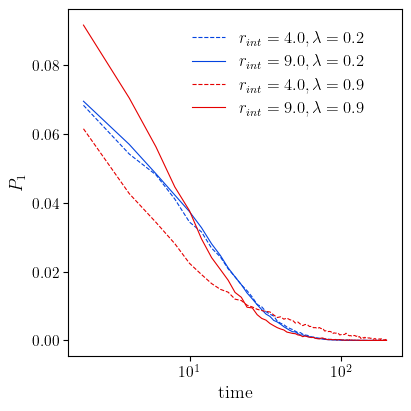

In [140]:
latexFont(titlesize=11, ticklabelssize=11, labelsize=13, legendsize=12)
fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)

ax.set(xscale='symlog', ylabel=r'$P_1$', xlabel='time')
for l,lcolor in zip(ls,['xkcd:blue', 'xkcd:red']):
    for ir,irlstyle in zip(irs,['--', '-']):
        pdf, bin_edges = np.histogram(times_spent_1_var_ir_l[(ir,l)], bins=100, range=(1,200), density=True)
        ax.plot((bin_edges[1:]+bin_edges[:-1])/2, pdf, lw=0.8, color=lcolor, ls=irlstyle, label=fr'$r_{{int}} = {ir}, \lambda = {l}$')
fig.legend(loc=(0.45,0.7), frameon=False)
fig.savefig('time_spent_1_var_ir_l.pdf')